In [12]:
#!/usr/bin/env python3

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt

# create and prepare the mujoco instance
mj = MjEnv()
mj.testing_xmls = 0
mj.task_reload_chance = -1

# define the names of the object sets we want to investigate
object_set_folder = "free_first_joint"
object_sets = [
  "set_test_seg5",
  "set_test_seg6",
  "set_test_seg7",
  "set_test_seg8",
  "set_test_seg9",
  "set_test_seg10",
  "set_test_seg15",
  "set_test_seg20",
  "set_test_seg25",
  "set_test_seg30"
]

# list of stable timesteps for each object set
mujoco_timesteps = [
  0.00353,
  0.0024,
  0.00176,
  0.00133,
  0.00102,
  0.000841,
  0.000334,
  0.000198,
  10E-05, #not measured
  8.42E-05
]

# initialise/wipe variables
data = []
num_sets = len(object_sets)

In [13]:
from FEA_data import FEA_1N, FEA_2N, FEA_3N, FEA_4N, FEA_5N

FEA_xy = [
  1e-3 * np.array(FEA_1N),
  1e-3 * np.array(FEA_2N),
  1e-3 * np.array(FEA_3N),
  1e-3 * np.array(FEA_4N),
  1e-3 * np.array(FEA_5N)]

In [14]:
# TODO: add in code to detect automatically the highest stable timestep

In [15]:
# loop through each object set and gather data
done_one = False
for i in range(0, num_sets):

  # if done_one: break

  set_name = object_set_folder + "/" + object_sets[i]
  mj._load_object_set(name=set_name)
  mj._load_xml()
  mj.mj.set.mujoco_timestep = mujoco_timesteps[i] * 0.5
  mj.reset(hard=True)

  # run the validation regime
  print("Curve validation running for object set:", object_sets[i])
  print_out = False
  finger_data = mj.mj.curve_validation_regime(print_out)
  data.append(finger_data)

  done_one = True

Curve validation running for object set: set_test_seg5
Curve validation running for object set: set_test_seg6
Curve validation running for object set: set_test_seg7
Curve validation running for object set: set_test_seg8
Curve validation running for object set: set_test_seg9
Curve validation running for object set: set_test_seg10
Curve validation running for object set: set_test_seg15
Curve validation running for object set: set_test_seg20
Curve validation running for object set: set_test_seg25
Curve validation running for object set: set_test_seg30


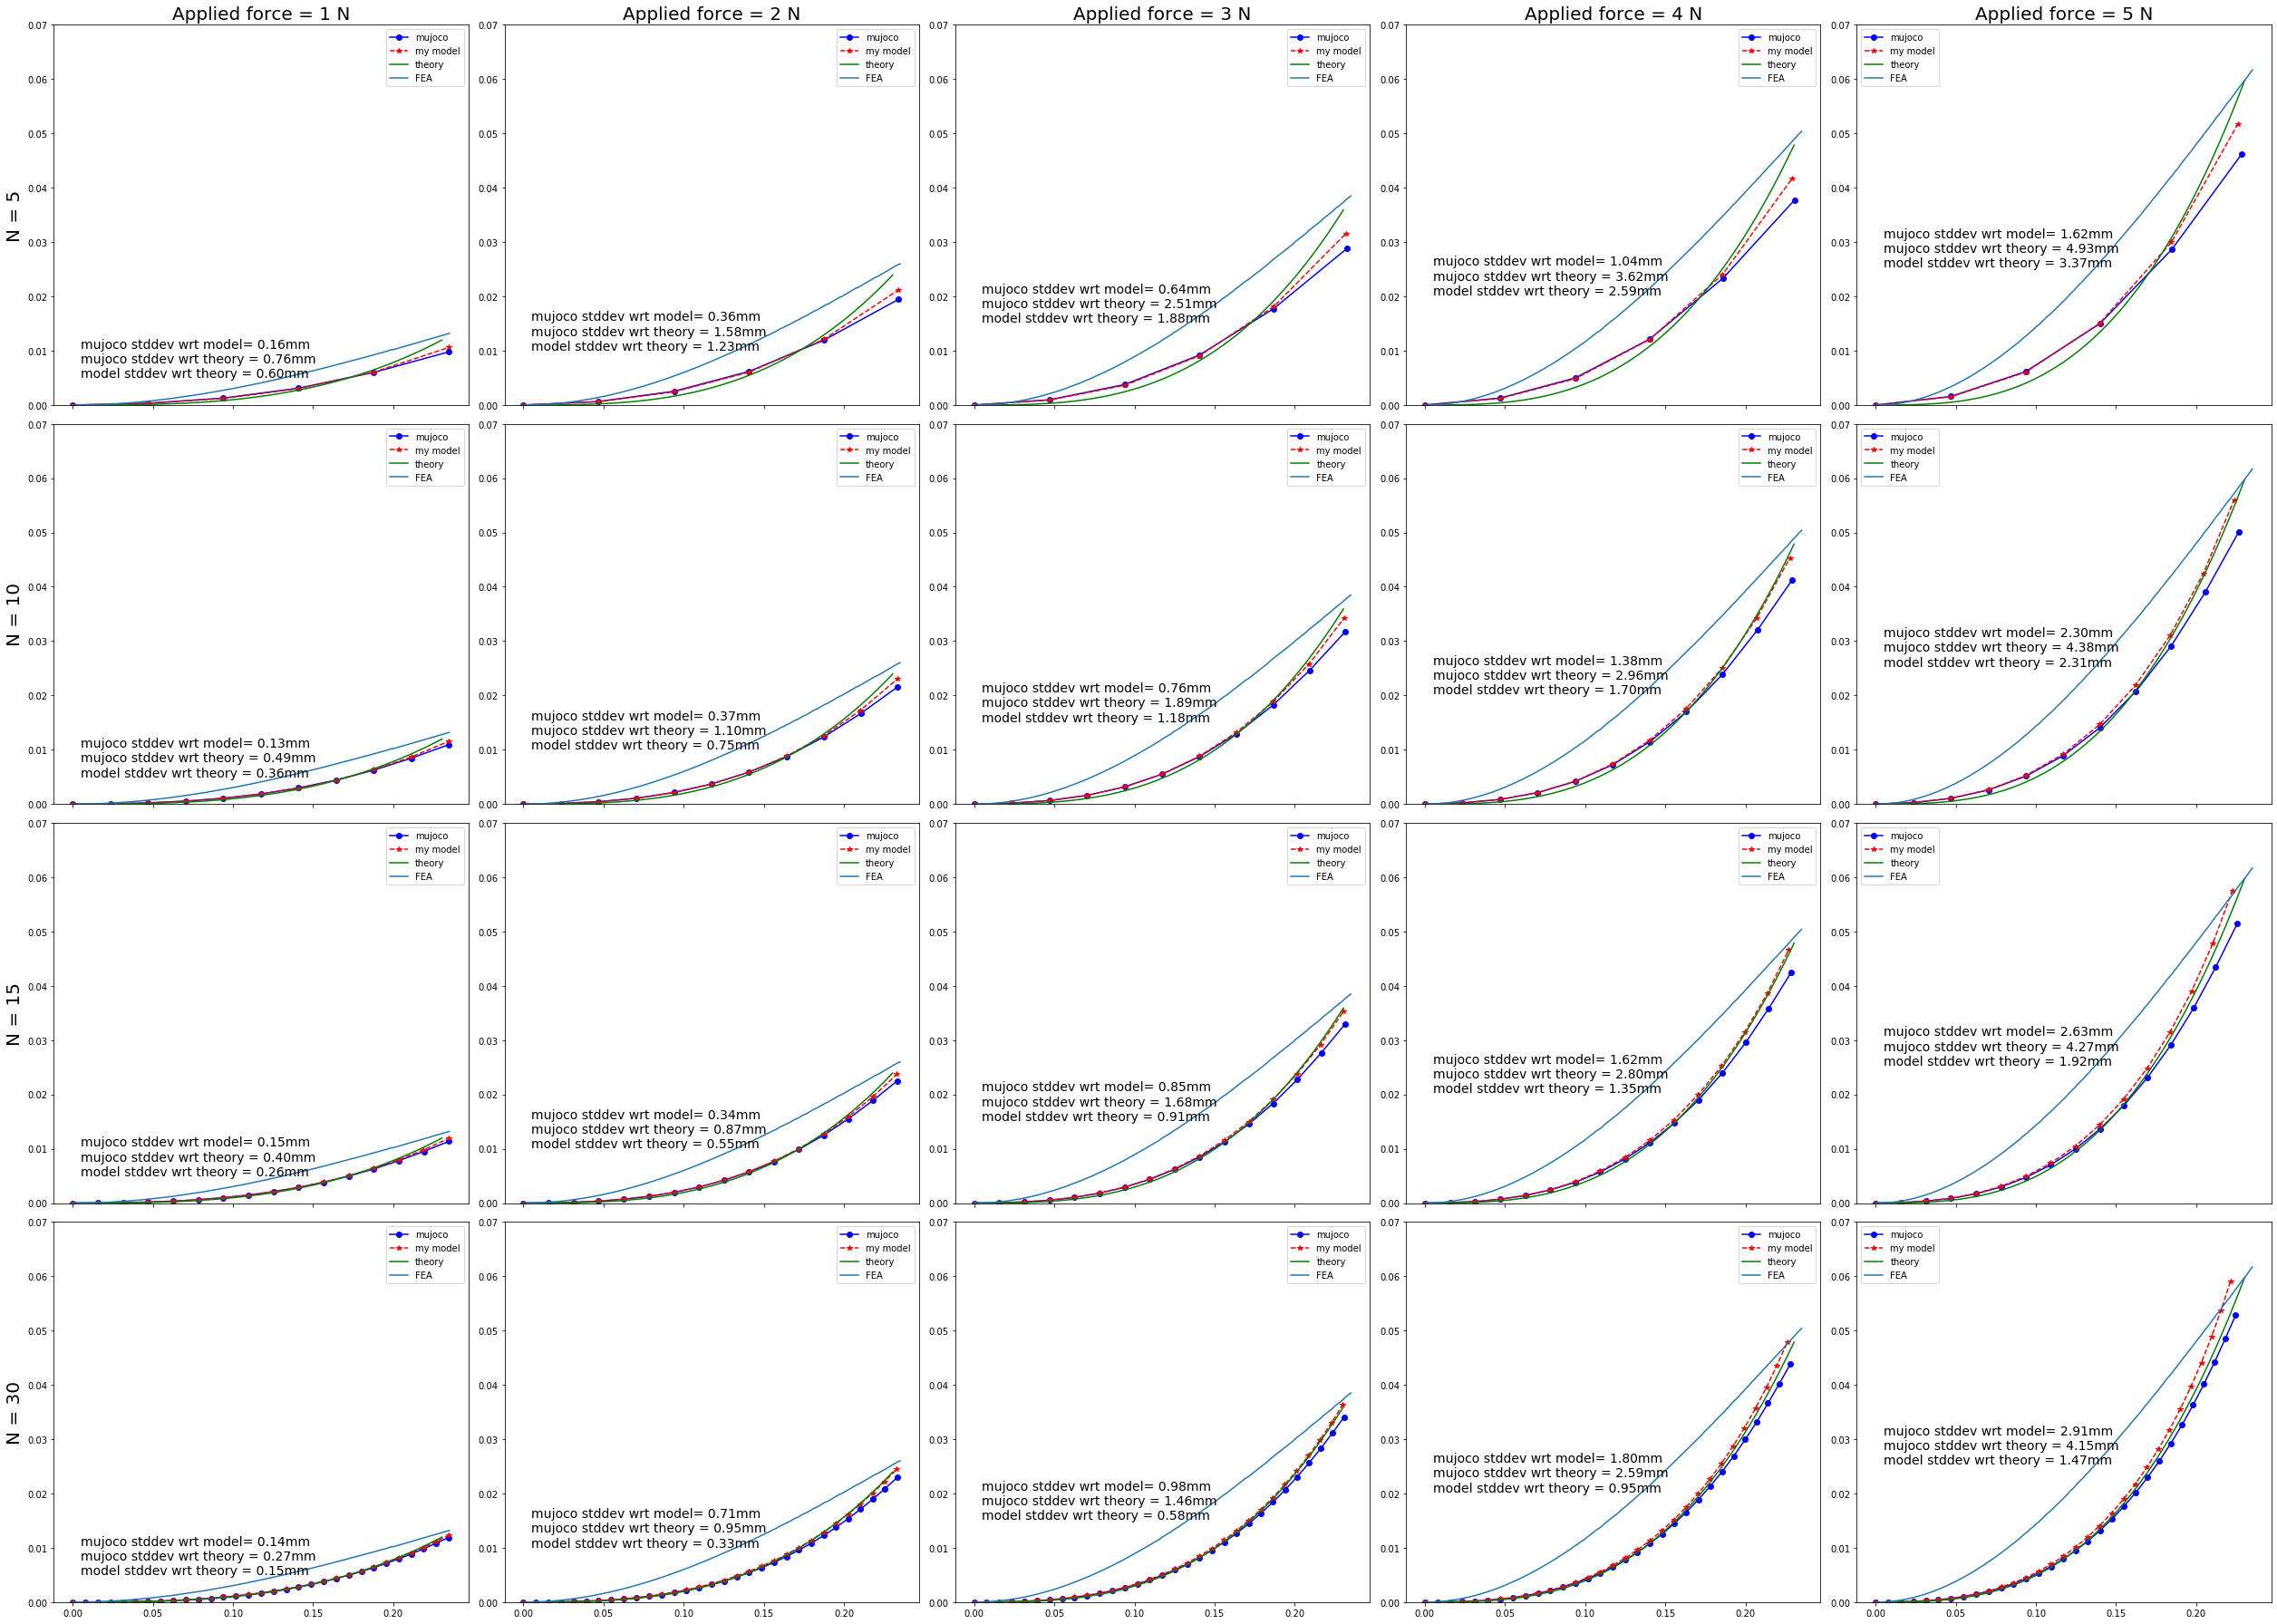

In [16]:
# now process the data and plot it

entries = list(range(num_sets))
entries = [0, 5, 6, 9]

forces = list(range(1, 6))

fig, axs = plt.subplots(len(entries), len(forces), sharex=True)

for i, force in enumerate(forces):
  for j, ind in enumerate(entries):

    # lets start by plotting a basic example
    x =        np.array(data[ind].entries[i].f1.x)
    y =        np.array(data[ind].entries[i].f1.y)
    pred_x =   np.array(data[ind].entries[i].f1.pred_x)
    pred_y =   np.array(data[ind].entries[i].f1.pred_y)
    theory_x = np.array(data[ind].entries[i].f1.theory_x_curve)
    theory_y = np.array(data[ind].entries[i].f1.theory_y_curve)

    axs[j][i].plot(x,        y,        "b-o",  label="mujoco")
    axs[j][i].plot(pred_x,   pred_y,   "r--*", label="my model")
    axs[j][i].plot(theory_x, theory_y, "g",    label="theory")
    axs[j][i].plot(FEA_xy[i][:,0], FEA_xy[i][:,1], label="FEA")
    
    temp_N = len(data[ind].entries[force - 1].f1.y) - 1
    axs[j][i].text(0.005, data[ind].entries[force - 1].f1.theory_y[-1] * 0.4,
      f"mujoco stddev wrt model= {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_pred_y:.2f}mm\n" +
      f"mujoco stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_wrt_theory_y:.2f}mm\n" +
      f"model stddev wrt theory = {1000 * data[ind].entries[force - 1].f1.error.std_y_pred_wrt_theory_y:.2f}mm",
      fontsize=14)
    # axs[j][i].axis("equal")
    axs[j][i].legend()
    axs[j][i].set(ylim=(0, 70e-3))

    if j == 0:
      axs[j][i].set_title(f"Applied force = {force} N", fontsize=20)
    if i == 0:
      axs[j][i].set_ylabel(f"N = {temp_N}", fontsize=20, rotation=90)

fig.set_size_inches(35, 25)
fig.tight_layout()

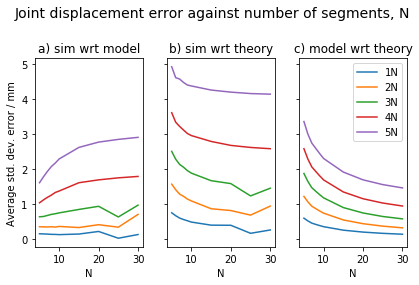

In [45]:
fig2, axs2 = plt.subplots(1, 3, sharey=True)

# get std deviation data
dev_y_wrt_pred_y = np.zeros((num_sets, len(forces)))
dev_y_wrt_theory_y = np.zeros((num_sets, len(forces)))
dev_y_pred_wrt_theory_y = np.zeros((num_sets, len(forces)))

labels = ["1N", "2N", "3N", "4N", "5N"]
sets_N = []

for i in range(num_sets):

  sets_N.append(len(data[i].entries[forces[j] - 1].f1.y) - 1)

  for j in range(len(forces)):

    dev_y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.std_y_wrt_pred_y * 1000
    dev_y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.std_y_wrt_theory_y * 1000
    dev_y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.std_y_pred_wrt_theory_y * 1000

axs2[0].plot(np.array(sets_N), dev_y_wrt_pred_y)
axs2[1].plot(np.array(sets_N), dev_y_wrt_theory_y)
lines = axs2[2].plot(np.array(sets_N), dev_y_pred_wrt_theory_y)
plt.legend(iter(lines), labels)

axs2[0].set_title("a) sim wrt model")
axs2[1].set_title("b) sim wrt theory")
axs2[2].set_title("c) model wrt theory")
axs2[0].set(ylabel="Average std. dev. error / mm", xlabel="N")
axs2[1].set(xlabel="N")
axs2[2].set(xlabel="N")
fig2.suptitle("Joint displacement error against number of segments, N", fontsize=14)
fig2.tight_layout()
fig2.subplots_adjust(top=0.8)


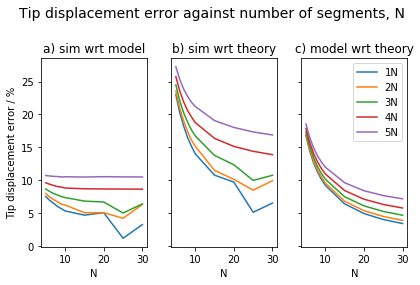

In [46]:
fig3, axs3 = plt.subplots(1, 3, sharey=True)

# get tip error data
tip_y_wrt_pred_y = np.zeros((num_sets, len(forces)))
tip_y_wrt_theory_y = np.zeros((num_sets, len(forces)))
tip_y_pred_wrt_theory_y = np.zeros((num_sets, len(forces)))

labels = ["1N", "2N", "3N", "4N", "5N"]
sets_N = []

for i in range(num_sets):

  sets_N.append(len(data[i].entries[forces[j] - 1].f1.y) - 1)

  for j in range(len(forces)):

    # # abs value
    # tip_y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y * 1000
    # tip_y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y * 1000
    # tip_y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y * 1000

    # percentage
    tip_y_wrt_pred_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_pred_y_percent * 100
    tip_y_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_tip_wrt_theory_y_percent * 100
    tip_y_pred_wrt_theory_y[i, j] = data[i].entries[forces[j] - 1].f1.error.y_pred_tip_wrt_theory_y_percent * 100

axs3[0].plot(np.array(sets_N), tip_y_wrt_pred_y)
axs3[1].plot(np.array(sets_N), tip_y_wrt_theory_y)
lines = axs3[2].plot(np.array(sets_N), tip_y_pred_wrt_theory_y)
plt.legend(iter(lines), labels)

axs3[0].set_title("a) sim wrt model")
axs3[1].set_title("b) sim wrt theory")
axs3[2].set_title("c) model wrt theory")
axs3[0].set(ylabel="Tip displacement error / %", xlabel="N")
axs3[1].set(xlabel="N")
axs3[2].set(xlabel="N")
fig3.suptitle("Tip displacement error against number of segments, N", fontsize=14)
fig3.tight_layout()
fig3.subplots_adjust(top=0.8)